In [1]:
import os
os.environ['DT'] = '1'
os.environ['NX'] = '16'
os.environ['N_STEPS'] = '64'
os.environ['N_ITERS'] = '3'
os.environ['N_REPEATS'] = '4'
os.environ['MAX_THREADS'] = '3'

figsize = (4.5, 5)
linewidth = 1.5

In [2]:
import subprocess
import numpy as np
import sys
import json
import timeit
import numba
import matplotlib
from matplotlib import pyplot
from atmos_cloud_sim_uj_utils import show_plot

### 0. compilation of libmpdata++-based solver

In [15]:
! mkdir -p build; cd build; cmake ..; make; cd ..

-- Detecting if the compiler is an MPI wrapper...
-- Detecting if the compiler is an MPI wrapper... - FALSE
-- gnuplot-iostream not found.

* Programs using libmpdata++'s gnuplot-iostream output will not compile.
* To install gnuplot-iostream, please try:
*   Debian/Ubuntu: sudo apt-get install libgnuplot-iostream-dev
*   manual: wget -O /usr/local/include/gnuplot-iostream.h https://raw.githubusercontent.com/dstahlke/gnuplot-iostream/master/gnuplot-iostream.h
  
-- Configuring done
-- Generating done
-- Build files have been written to: /home/slayoo/devel/PyMPDATA-examples/PyMPDATA_examples/Bartman_et_al_2022/build
[100%] Built target revolving_sphere_3d


### 1. scaling with number of threads

In [16]:
data_th_libmpdata = {}
for n_thread in range(1, int(os.environ['MAX_THREADS'])+1):
    value = np.inf
    for _ in range(int(os.environ['N_REPEATS'])):
        info = subprocess.run(
            ["build/revolving_sphere_3d"],
            capture_output=True,
            env={**os.environ, "OMP_NUM_THREADS": str(n_thread)}
        )
        if info.returncode != 0:
            print(info)
            assert False
        value = min(value, float(str(info.stderr).split(" ")[3][:-1]))
    data_th_libmpdata[str(n_thread)] = value / int(os.environ['N_STEPS'])
print(data_th_libmpdata)

{'1': 0.001488934375, '2': 0.00078035625, '3': 0.0005796171875}


In [28]:
for ndj in ('0', '1'):
    info = subprocess.run(
        [sys.executable, "revolving_sphere_3d.py"],
        capture_output=True,
        env={**os.environ, 'NUMBA_DISABLE_JIT': ndj}
    )
    if info.returncode != 0:
        print(info)
        assert False
data_th_pympdata = {}
for ndj in ('0', '1'):
    with open(f'data_NDJ={ndj}.json', 'r') as file:
        for k, v in json.load(file).items():
            data_th_pympdata[k] = v
print(data_th_pympdata)

{'static': {'1': 0.00029381139676034864, '2': 0.0001640260317279691, '3': 0.0001193763492333274}, 'dynamic': {'1': 0.0002953780953363988, '2': 0.0001764729999454825, '3': 0.00013069604756310582}, 'nojit': 0.7840088012062119}


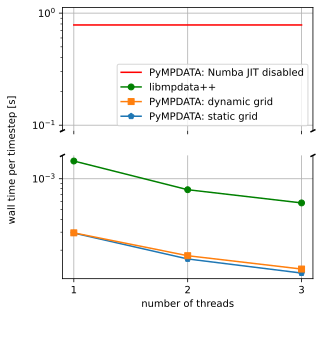

HTML(value="<a href='./fig_X.pdf' target='_blank'>./fig_X.pdf</a><br>")

In [29]:
fig, (ax1, ax2) = pyplot.subplots(2, 1, sharex=True, figsize=figsize)            
handles = []

for grid, marker in {'static': 'p', 'dynamic': 's'}.items():
    handles.append(ax2.plot(
        data_th_pympdata[grid].keys(),
        np.asarray(list(data_th_pympdata[grid].values())),
        label=f'PyMPDATA: {grid} grid',
        linewidth=linewidth, marker=marker
    )[0])
handles.append(ax2.plot(
    data_th_libmpdata.keys(),
    np.asarray(list(data_th_libmpdata.values())),
    label="libmpdata++",
    linewidth=linewidth, color='green', marker='o'
)[0])

x = list(data_th_pympdata['static'].keys())
handles.append(ax1.plot(
    x, 
    np.full((len(x),), data_th_pympdata['nojit']),
    label='PyMPDATA: Numba JIT disabled',
    linewidth=linewidth, color='red'
)[0])

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)
ax2.xaxis.tick_bottom()

d = .0075  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

for ax in (ax1, ax2):
    ax.grid()
    ax.set_yscale('log')

ax1.legend(handles=handles[-1::-1], loc='lower right')

pyplot.xlabel("number of threads")
pyplot.ylabel("                                    wall time per timestep [s]\n")
show_plot('fig_X.pdf')

### 2. scaling with domain size

In [4]:
nxs = (8, 16, 32, 64, 128)

In [26]:
data_nx_libmpdata = {}
for nx in nxs:
    value = np.inf
    for _ in range(int(os.environ['N_REPEATS'])):
        info = subprocess.run(
            ["build/revolving_sphere_3d"],
            capture_output=True,
            env={
                **os.environ,
                "OMP_NUM_THREADS": os.environ['MAX_THREADS'],
                "NX": str(nx),
                "DT": str(float(os.environ['DT']) * float(os.environ['NX']) / nx)
            }
        )
        if info.returncode != 0:
            print(info)
            assert False
        value = min(value, float(str(info.stderr).split(" ")[3][:-1]))
    data_nx_libmpdata[nx] = value / int(os.environ['N_STEPS'])
print(data_nx_libmpdata)

{8: 0.0001927921875, 16: 0.0006529734375, 32: 0.002641453125, 64: 0.01698765625, 128: 0.1927125}


In [5]:
from revolving_sphere_3d import time_pympdata

numba.set_num_threads(int(os.environ['MAX_THREADS']))

data_nx_pympdata = {}
for nx in nxs:
    dt = float(os.environ['DT']) * float(os.environ['NX']) / nx
    data_nx_pympdata[nx] = time_pympdata(
        static=False,
        n_threads=int(os.environ['MAX_THREADS']),
        nx=nx,
        dt=dt,
        nt=int(os.environ['N_STEPS']),
        repeat=int(os.environ['N_REPEATS'])
    )
print(data_nx_pympdata)

{8: 3.289303172745609e-05, 16: 0.00015715063486750874, 32: 0.0008897354284907499, 64: 0.007388255587318868, 128: 0.0609263318253816}


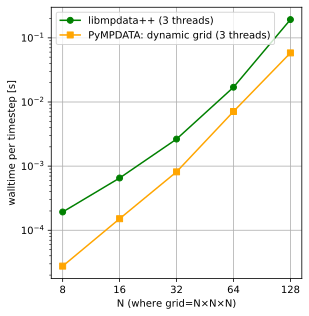

HTML(value="<a href='./fig_Y.pdf' target='_blank'>./fig_Y.pdf</a><br>")

In [27]:
fig, ax = pyplot.subplots(1, 1, figsize=figsize)  
ax.plot(
    data_nx_libmpdata.keys(),
    np.asarray(list(data_nx_libmpdata.values())),
    label=f"libmpdata++ ({os.environ['MAX_THREADS']} threads)",
    marker='o', color='green', linewidth=linewidth
)
ax.plot(
    data_nx_pympdata.keys(),
    np.asarray(list(data_nx_pympdata.values())),
    label=f"PyMPDATA: dynamic grid ({os.environ['MAX_THREADS']} threads)",
    marker='s', color='orange', linewidth=linewidth
)
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.xaxis.set_ticks(nxs, minor=False)
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_ticks([], minor=True)
ax.grid()
ax.set_ylabel('walltime per timestep [s]')
ax.set_xlabel('N (where grid=N$\\times$N$\\times$N)')
show_plot('fig_Y.pdf')